In [1]:
import gymnasium
import gymnasium.logger
import gymnasium.wrappers.record_video
import numpy as np
import tensorflow
import tensorflow.keras
import tensorflow.keras.layers
import uuid
import typing
import matplotlib.pyplot as plt

# Create Environment

In [2]:
def create_environment(name, video: bool = True):
    """
    Create an OpenAI Gym environment with optional video recording.

    Parameters:
    - name (str): The name of the OpenAI Gym environment.
    - video (bool): Flag indicating whether to record videos (default is True).

    Returns:
    - env (gym.Env): The created OpenAI Gym environment.
    - folder_name (str or None): The folder path where video recordings will be saved if video is enabled,
                                 otherwise, None.
    """
    # Generate a unique folder name for video recordings
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    
    # Create the OpenAI Gym environment with RGB rendering
    env = gymnasium.make(name, render_mode="rgb_array")

    if video:
        # Wrap the environment to record video with specified folder and disable logger
        env = gymnasium.wrappers.record_video.RecordVideo(env, folder_name, disable_logger=True)
        return env, folder_name
    else:
        return env, None

# Q-Table implementation

In [3]:
class QTable:
    """
    A simple Q-table-based reinforcement learning agent.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - learning_rate (float): The learning rate for updating Q-values (default is 0.3).
    - discount_factor (float): The discount factor for future rewards in Q-value updates (default is 0.7).
    """
    def __init__(self, action_space: int, state_space: int, learning_rate: float = 0.3, discount_factor: float = 0.7):
        # Initialize the Q-table with random values
        self.q = np.random.random((state_space, action_space))
        self.alpha = learning_rate  # Learning rate for Q-value updates
        self.gamma = discount_factor  # Discount factor for future rewards

    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        """
        Update Q-values based on experienced transitions.

        Parameters:
        - states (List[int]): List of current states.
        - next_states (List[int]): List of next states.
        - actions_taken (List[int]): List of actions taken.
        - rewards (List[float]): List of rewards received.
        """
        for i in range(len(states)):
            state = states[i]
            next_state = next_states[i]
            action_taken = actions_taken[i]
            reward = rewards[i]

            # Q-value update using the Q-learning formula
            self.q[state][action_taken] = self.q[state][action_taken] + self.alpha * (
                reward + self.gamma * self.max_reward(next_state) - self.q[state][action_taken]
            )

    def max_reward(self, state: int) -> float:
        """
        Get the maximum Q-value for a given state.

        Parameters:
        - state (int): The state for which the maximum Q-value is to be obtained.

        Returns:
        - float: The maximum Q-value for the specified state.
        """
        return max(self.qt(state))

    def qt(self, state: int) -> typing.List[float]:
        """
        Get the list of Q-values for all actions in a given state.

        Parameters:
        - state (int): The state for which Q-values are to be obtained.

        Returns:
        - List[float]: The list of Q-values for all actions in the specified state.
        """
        return list(self.q[state])

In [4]:
class QNeural:
    """
    A neural network-based Q-learning agent.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - discount_factor (float): The discount factor for future rewards in Q-value updates (default is 0.7).
    """
    def __init__(self, action_space: int, state_space: int, discount_factor: float = 0.7):
        self.state_space = state_space
        self.action_space = action_space
        self.gamma = discount_factor

        # Define a neural network model using Keras
        self.model = tensorflow.keras.Sequential([
            tensorflow.keras.layers.Input(shape=(state_space,)),
            tensorflow.keras.layers.Dense(512, activation="relu"),
            tensorflow.keras.layers.Dense(action_space, activation="linear"),
        ])
        self.model.compile(loss='mse', optimizer=tensorflow.keras.optimizers.legacy.Adam())

    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        """
        Update the neural network's weights based on experienced transitions.

        Parameters:
        - states (List[int]): List of current states.
        - next_states (List[int]): List of next states.
        - actions_taken (List[int]): List of actions taken.
        - rewards (List[float]): List of rewards received.
        """
        state_one_hot = tensorflow.one_hot(states, self.state_space)
        state_next_one_hot = tensorflow.one_hot(next_states, self.state_space)
        masks = tensorflow.one_hot(actions_taken, self.action_space)

        # Predict Q-values for the next states
        target = self.model.predict(state_next_one_hot, verbose=0)
        for i in range(len(rewards)):
            r = masks[i] * rewards[i]
            target[i] += (self.gamma * r)

        # Update the model's weights using the modified Q-values
        self.model.fit(state_one_hot, target, epochs=1, verbose=0)

    def qt(self, state: int) -> int:
        """
        Get the action with the highest Q-value for a given state.

        Parameters:
        - state (int): The state for which the action with the highest Q-value is to be obtained.

        Returns:
        - int: The selected action.
        """
        state_tensor = tensorflow.one_hot(state, self.state_space)
        state_tensor = tensorflow.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        action = tensorflow.argmax(action_probs[0]).numpy()
        return action

# Selection Methods

In [17]:
class EpsilonGreedy:
    """
    An epsilon-greedy exploration strategy for action selection.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - epsilon_decay (float): The rate at which the exploration probability epsilon decays (default is 0.99).
    """
    def __init__(self, action_space: int, state_space: int, epsilon_decay: float = 0.99):
        self.epsilon = 1  # Initial exploration probability
        self.epsilon_decay = epsilon_decay  # Rate at which epsilon decays
        self.action_space = action_space  # Number of possible actions
        self.state_space = state_space  # Number of possible states

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using epsilon-greedy strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        n = np.random.rand()  # Random number from a uniform distribution [0, 1)

        if n < self.epsilon:
            action = np.random.randint(0, self.action_space)  # Random exploration
        else:
            action = np.argmax(q)  # Exploitation, choose action with highest Q-value
            
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay  # Decay epsilon over time

        return action

In [6]:
class UpperConfidenceBound:
    """
    An Upper Confidence Bound (UCB) exploration strategy for action selection.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - p_decay (float): The parameter controlling the exploration-exploitation balance (default is 4.0).
    """
    def __init__(self, action_space: int, state_space: int, p_decay: float = 4.0):
        self.p_decay = p_decay  # Parameter controlling exploration-exploitation balance
        self.t = 1  # Time step
        self.action_space = action_space  # Number of possible actions
        self.state_space = state_space  # Number of possible states
        self.count_selected = np.ones((state_space, action_space))  # Count of selections for each action

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using the Upper Confidence Bound (UCB) strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        ut = np.sqrt(
            (self.p_decay * np.log(self.t)) / np.array(self.count_selected[state])
        )
        qt = np.array(q) + ut
        
        # Choose the action with the highest UCB-augmented Q-value
        action = max(enumerate(qt), key=lambda n: n[1])[0]

        # Update selection count and time step
        self.count_selected[state][action] += 1
        self.t += 1

        return action

In [7]:
class BoltzmannExploration:
    
    """
    An agent using the Boltzmann exploration strategy for action selection.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - temperature (float): The temperature parameter controlling exploration (default is 1.0).
    """

    def __init__(self, action_space: int, state_space: int, temperature: float = 1.0):
        self.action_space = action_space
        self.state_space = state_space
        self.temperature = temperature

    
    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using the Boltzmann exploration strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        # Calculate the probabilities of each action using the Boltzmann formula
        probabilities = np.exp(np.array([q_value / self.temperature for q_value in q]))
        probabilities /= np.sum(probabilities)

        # Choose an action based on the calculated probabilities
        action = np.random.choice(self.action_space, p=probabilities)

        return action

In [22]:
class ThompsonSampling:
    """
    A ThompsonSampling exploration strategy for action selection.
    
    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    """
    def __init__(self, action_space: int, state_space: int):
        self.action_space = action_space  # Number of possible actions
        self.state_space = state_space  # Number of possible states
        self.std_dev = np.ones((state_space, action_space))  # Standard deviation for each action's Q-value

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using the Thompson Sampling strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        sampled_q_values = np.random.normal(q, self.std_dev[state])
        return np.argmax(sampled_q_values)

    def update(self, state: int, next_state: int, action: int, next_action: int, reward: int, q_table: typing.List[typing.Tuple[int, float]], discount_factor:float = 0.9):
        """
        Calculate the Temporal Difference error and update the standard deviation.

        Args:
            state (int): current state
            next_state (int): next state
            action (int): current action
            next_action (int): next action
            reward (int): reward
            q_table (typing.List[typing.Tuple[int, float]]): Q-table
            discount_factor (float, optional): discount factor (defaults to 0.9)
        """
        # Calculate the TD error
        q_current = q_table[state, action]  # Current Q-value
        q_next = q_table[next_state, next_action]  # Next Q-value
        td_error = reward + discount_factor * q_next - q_current  # TD Error

        # Update the standard deviation
        self.std_dev[state][action] *= np.exp(-np.abs(td_error))

# Learning Algorithm

In [29]:
def learn(env, num_episodes: int, selection_method, learning_method, print_episodes: bool = False):
    """
    Train a reinforcement learning agent using a specified selection method and learning method.

    Parameters:
    - env: The OpenAI Gym environment.
    - num_episodes (int): The number of episodes to train the agent.
    - selection_method: The exploration strategy for action selection.
    - learning_method: The learning method used to update the agent's knowledge.
    - print_episodes (bool): Flag indicating whether to print the episode number (default is False).

    Returns:
    - episode_mean_reward (List[float]): List containing the mean reward for each episode during training.
    """
    batch_size = 64
    update_after_actions = 32
    max_steps_per_episode = 1000
    
    # Initialize the learning and selection methods
    l = learning_method(env.action_space.n, env.observation_space.n)
    s = selection_method(env.action_space.n, env.observation_space.n)

    episode_mean_reward = []

    for episode in range(num_episodes):
        round = 0
        rewards_history = []
        action_history = []
        state_history = []
        state_next_history = []

        if episode % 20 == 0 and print_episodes:
            print(f"Episode {episode}...")
        
        observation, state = env.reset()
        done = False

        while not done and round < max_steps_per_episode:
            round += 1
            
            # Select the next action using the specified selection method
            action = s.next_action(l.qt(observation), observation)

            old_observation = observation
            observation, reward, done, _, state = env.step(action)
            
            if s.__class__ == ThompsonSampling:
                s.update(old_observation, observation, action, s.next_action(l.qt(observation), observation), reward, l.q)

            # Store the information for experience replay
            rewards_history.append(reward)
            action_history.append(action)
            state_history.append(old_observation)
            state_next_history.append(observation)
            

            # Perform learning updates after a certain number of actions
            if round % update_after_actions == 0 and len(rewards_history) > batch_size:
                indices = list(range(len(rewards_history) - batch_size, len(rewards_history)))
                
                state_sample = [state_history[i] for i in indices]
                state_next_sample = [state_next_history[i] for i in indices]
                action_sample = [action_history[i] for i in indices]
                rewards_sample = [rewards_history[i] for i in indices]
            
                # Update the agent's knowledge using the specified learning method
                l.update(state_sample, state_next_sample, action_sample, rewards_sample)

        episode_mean_reward.append(np.mean(rewards_history))

    env.close()
    return episode_mean_reward

# Model training

In [ ]:
# Create the environment without video recording
env, folder_name = create_environment("Taxi-v3", False)

# Train the agent using Upper Confidence Bound for action selection and QNeural for learning
rewards = learn(env, 100, UpperConfidenceBound, QNeural, print_episodes = True)

# Display information about video recording folder
print(f"Video in {folder_name}")

# Calculate rolling mean of rewards for smoother visualization
window = 20
average_reward = []
for _ in range(window - 1):
    average_reward.insert(0, np.nan)
for x in range(len(rewards) - window + 1):
     average_reward.append(np.mean(rewards[x:x+window]))

# Plot the rewards and rolling mean rewards
plt.plot(rewards, label="Reward")
plt.plot(average_reward, label="Rolling mean reward")
plt.legend()
plt.show()

Training with EpsilonGreedy...
EpsilonGreedy Video in ./video/Taxi-v3/dd0ea717-58a9-4988-8c22-f42e6b6a64c6


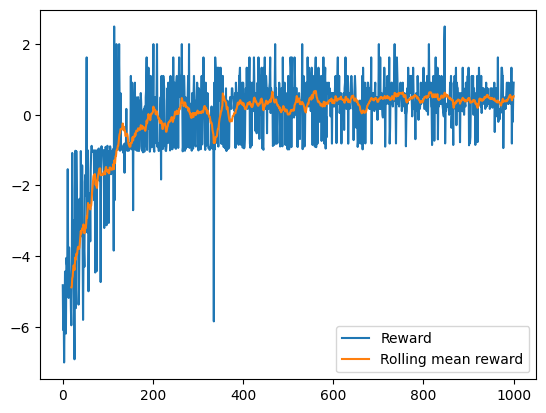

Training with UpperConfidenceBound...
UpperConfidenceBound Video in ./video/Taxi-v3/dd0ea717-58a9-4988-8c22-f42e6b6a64c6


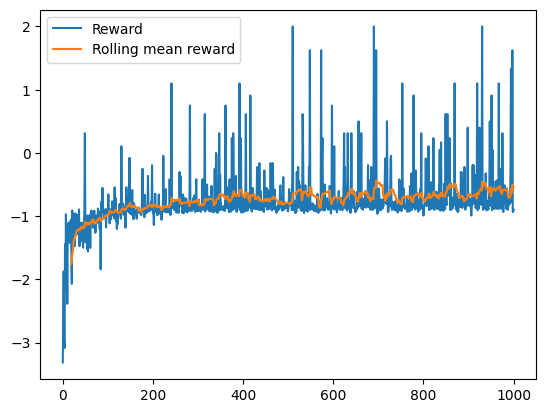

Training with BoltzmannExploration...
BoltzmannExploration Video in ./video/Taxi-v3/dd0ea717-58a9-4988-8c22-f42e6b6a64c6


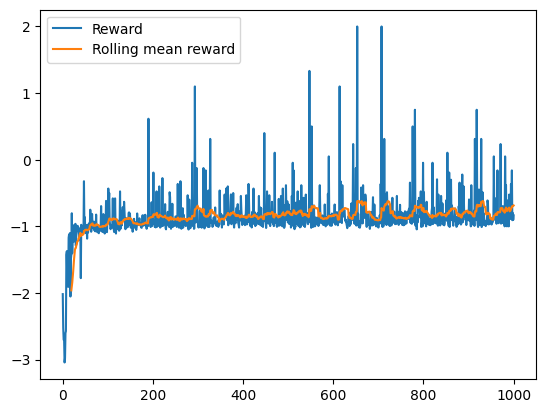

Training with ThompsonSampling...
ThompsonSampling Video in ./video/Taxi-v3/dd0ea717-58a9-4988-8c22-f42e6b6a64c6


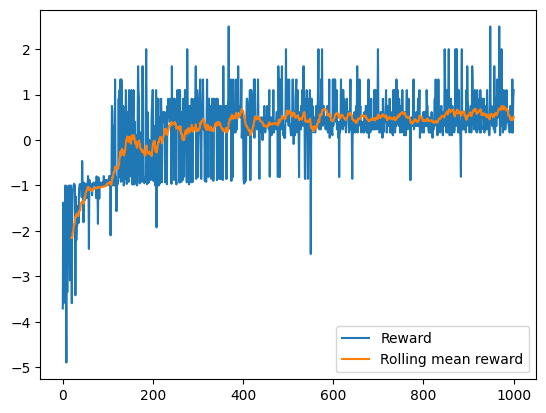

In [31]:
def train_and_plot(env, num_episodes, action_selections, learning_method, window=20):
    for action_selection in action_selections:
        print(f"Training with {action_selection.__name__}...")
        # Train the agent using the specified action selection method and learning method
        rewards = learn(env, num_episodes, action_selection, learning_method)

        # Display information about video recording folder
        print(f"{action_selection.__name__} Video in {folder_name}")

        # Calculate rolling mean of rewards for smoother visualization
        average_reward = [np.nan]*(window - 1)
        for x in range(len(rewards) - window + 1):
            average_reward.append(np.mean(rewards[x:x+window]))

        # Plot the rewards and rolling mean rewards
        plt.plot(rewards, label="Reward")
        plt.plot(average_reward, label="Rolling mean reward")
        plt.legend()
        plt.show()

# Create the environment with video recording
env, folder_name = create_environment("Taxi-v3", True)

# List of action selection methods
action_selections = [EpsilonGreedy, UpperConfidenceBound, BoltzmannExploration, ThompsonSampling]

# Call the function
train_and_plot(env, 1001, action_selections, QTable)